## PINN求解微分方程

对于微分方程：  
$$
\mathcal{F}(u(z);\gamma)=f(z),z\in \Omega\\
\mathcal{B}(u(z))=g(z),z\in \partial \Omega\\ 
\mathcal{D}(u(z_i))=d(z_i),i\in D
$$
其中：
$z$ 是包含了空间和时间的坐标；  
$u$ 表示方程的解；  
$\Omega$ 是方程所在的区域；  
$\mathcal{F}$ 算子描述了控制方程；  
$\gamma$ 是控制方程的参数；  
$\mathcal{B}$ 算子描述了初值或者边界条件；  
$\mathcal{D}$ 算子描述了观测数据的方式；  
$D$ 是观测数据指标集。  
以上的三个条件并不一定全部出现。  
然后PINN要做的，就是对解$u$，用神经网络进行逼近。将这个解用神经网络参数化表达为$u_{\theta}$，那么就是要寻找这组参数$\theta$，使得：$u_{\theta}(z)\approx u(z)$  
在定义了上述三个公式的残差之后，我们就可以得到由三项损失加权得到的总损失：  
$$
\mathcal{L}:=\omega_\mathcal{F}\mathcal{L}_\mathcal{F}+\omega_\mathcal{B}\mathcal{L}_\mathcal{B}+\omega_\mathcal{D}\mathcal{L}_\mathcal{D}
$$
我们也可以加入正则化项，由此问题转化为如下的优化问题：  
$$
\theta * \in  \underset{\theta}{{\arg\min}}\mathcal{L}[u_{\theta}]
$$
由此我们可以得到以下四个结论：  
1.PINN是一种（深度）网络，在定义时空区域中给定一个输入点，在训练后在微分方程的该点中产生估计的解。  
2.结合对控制方程的嵌入得到残差，利用残差构造损失项就是PINN的一项不太新奇的新奇之处了。本质原理就是将方程（也就是所谓的物理知识）集成到网络中，并使用来自控制方程的残差项来构造损失函数，由该项作为惩罚项来限制可行解的空间。  
3.用PINN来求解方程并不需要有标签的数据，比如先前模拟或实验的结果。从这个角度，对PINN 在深度学习中的地位进行定位的话，大概是处于无监督、自监督、半监督或者弱监督的地位，这几个不尽相同的说法在不同语境下都有文献提过。  
4.PINN算法本质上是一种无网格技术，通过将直接求解控制方程的问题转换为损失函数的优化问题来找到偏微分方程解。

以下使用pytorch来解决一个具体的偏微分方程：  
$$
\frac{\partial^2u}{\partial x^2}-\frac{\partial^4u}{\partial y^4}=(2-x^2)e^{-y}\\
u_{yy}(x,0)=u(x,0)=x^2\\
u_{yy}(x,1)=u(x,1)=x^2/e\\
u(0,y)=0,u(1,y)=e^{-y}
$$
其中$(x,y)\in \Omega,\Omega=[0,1]\times [0,1]$  
从上面的讨论中我们知道，对于这样的问题，我们只需要根据这七个方程写出相应的七个损失函数，即  
$$
L_1=\frac{1}{N_1}\sum\limits_{(x_i,y_i)\in \Omega}(\frac{\partial^2u(x_i,y_i)}{\partial x^2}-\frac{\partial^4u(x_i,y_i)}{\partial y^4}-(2-x_i^2)e^{-y_i})^2\\
L_2=\frac{1}{N_2}\sum\limits_{(x_i,y_i)\in [0,1]\times\{0\}}(u_{yy}(x_i,y_i)-x_i^2)^2\\
\dots\\
L_7=\frac{1}{N_7}\sum\limits_{(x_i,y_i)\in \{0\}\times[0,1]}(u(x_i,y_i)-exp(-y_i))^2\\
$$
其中梯度可以利用torch的自动求梯度求出。  
我们用PINN求其解并与其真实解$u(x,y)=x^2e^{-y}$做比较，代码如下：

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng=np.random.default_rng(0)

首先我们由上述的条件依次给出取点，采用随机取点

In [35]:
#采用随机取点，对于第一个式子，内部取点
def interior(n=1000):
    x=torch.rand(n,1).to(device)
    y=torch.rand(n,1).to(device)
    cond=(2-x**2)*torch.exp(-y)
    return x.requires_grad_(True),y.requires_grad_(True),cond

#第二个式子，下方取点
def down_yy(n=100):
    x=torch.rand(n,1).to(device)
    y=torch.zeros_like(x).to(device)
    cond=x**2
    return x.requires_grad_(True),y.requires_grad_(True),cond

#第三个式子，上方取点
def up_yy(n=100):
    x=torch.rand(n,1).to(device)
    y=torch.ones_like(x).to(device)
    cond=x**2/torch.e
    return x.requires_grad_(True),y.requires_grad_(True),cond

#第四个式子，下方取点
def down(n=100): 
    x=torch.rand(n,1).to(device)
    y=torch.zeros_like(x).to(device)
    cond=x**2
    return x.requires_grad_(True),y.requires_grad_(True),cond

#第五个式子，上方取点
def up(n=100): 
    x=torch.rand(n,1).to(device)
    y=torch.ones_like(x).to(device)
    cond=x**2/torch.e
    return x.requires_grad_(True),y.requires_grad_(True),cond

#第六个式子，左方取点
def left(n=100): 
    y=torch.rand(n,1).to(device)
    x=torch.zeros_like(y).to(device)
    cond=torch.zeros_like(y).to(device)
    return x.requires_grad_(True),y.requires_grad_(True),cond

#第七个式子，右方取点
def right(n=100): 
    y=torch.rand(n,1).to(device)
    x=torch.ones_like(y).to(device)
    cond=torch.exp(-y)
    return x.requires_grad_(True),y.requires_grad_(True),cond

接下来定义神经网络，也就是我们要的近似函数。

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        return self.net(x)

损失计算采用MSEloss，按照上面给出的七个式子定义损失函数：

In [5]:
loss=nn.MSELoss()

#采用递归定义导数
def gradients(u,x,order=1):
    if order==1:
        return torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    else:
        return gradients(gradients(u,x),x,order=order-1)
    
#式一，内部导数
def l_interior(u):
    x,y,cond=interior()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(gradients(uxy,x,2)-gradients(uxy,y,4),cond)

#式二，下导数
def l_down_yy(u):
    x,y,cond=down_yy()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(gradients(uxy,y,2),cond)

def l_up_yy(u):
    x,y,cond=up_yy()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(gradients(uxy,y,2),cond)

def l_down(u):
    x,y,cond=down()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(uxy,cond)

def l_up(u):
    x,y,cond=up()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(uxy,cond)

def l_left(u):
    x,y,cond=left()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(uxy,cond)

def l_right(u):
    x,y,cond=right()
    uxy=u(torch.cat([x,y],dim=1))
    return loss(uxy,cond)

接下来开始训练，目标函数即为所定义的神经网络

In [39]:
test_inter_x,test_inter_y,_=interior()
test_inter_xy=torch.cat([test_inter_x,test_inter_y],dim=1)
test_inter_real=(test_inter_x*test_inter_x*torch.exp(-test_inter_y))
test_bound_x=torch.cat([down()[0],up()[0],left()[0],right()[0]],dim=0)
test_bound_y=torch.cat([down()[1],up()[1],left()[1],right()[1]],dim=0)
test_bound_xy=torch.cat([test_bound_x,test_bound_y],dim=1)
test_bound_real=(test_bound_x*test_bound_x*torch.exp(-test_bound_y))
u=MLP().to(device)
optimizer=torch.optim.Adam(u.parameters(),lr=0.01)
step_lr=torch.optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.2)
min_loss=float('inf')
param=None
for epoch in range(3000):
    l_i=l_interior(u)
    l_yy=l_down_yy(u)
    loss_=l_i+\
        l_yy+\
        l_up_yy(u)+\
        l_down(u)+\
        l_up(u)+\
        l_left(u)+\
        l_right(u)
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    step_lr.step()
    if epoch%100==0:
        print("----epoch:{}----".format(epoch))
        print("train:")
        print("total_loss:{:.6f}".format(loss_))
        print("interior_loss:{:.8f}".format(l_i))
        print("down_yy_loss:{:.8f}".format(l_yy))
        u.eval()
        inter_test_loss=loss(u(test_inter_xy),test_inter_real)
        bound_test_loss=loss(u(test_bound_xy),test_bound_real)
        print("test:")
        print("interior_loss:{:.8f}".format(inter_test_loss.cpu().detach().numpy()))
        print("bound_loss:{:.8f}".format(bound_test_loss.cpu().detach().numpy()))
        total_loss=inter_test_loss+bound_test_loss
        if total_loss<min_loss:
            param=u.state_dict()
        u.train()
torch.save(param,'net.pt')

----epoch:0----
train:
total_loss:2.178323
interior_loss:1.10150790
down_yy_loss:0.15918712
test:
interior_loss:0.03739771
bound_loss:0.07334084
----epoch:100----
train:
total_loss:0.038416
interior_loss:0.01094038
down_yy_loss:0.01135367
test:
interior_loss:0.00102696
bound_loss:0.00278176
----epoch:200----
train:
total_loss:0.002742
interior_loss:0.00081291
down_yy_loss:0.00109473
test:
interior_loss:0.00006628
bound_loss:0.00016979
----epoch:300----
train:
total_loss:0.002759
interior_loss:0.00140852
down_yy_loss:0.00045626
test:
interior_loss:0.00016719
bound_loss:0.00034058
----epoch:400----
train:
total_loss:0.001116
interior_loss:0.00038120
down_yy_loss:0.00039765
test:
interior_loss:0.00001177
bound_loss:0.00005158
----epoch:500----
train:
total_loss:0.001829
interior_loss:0.00101874
down_yy_loss:0.00024673
test:
interior_loss:0.00062669
bound_loss:0.00054256
----epoch:600----
train:
total_loss:0.001217
interior_loss:0.00056476
down_yy_loss:0.00044482
test:
interior_loss:0.0001

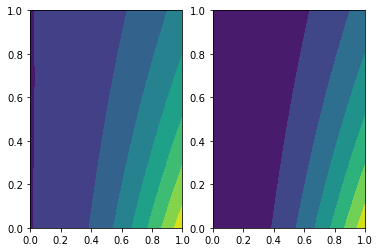

In [41]:
net=MLP()
net.load_state_dict(torch.load('net.pt'))
xc=torch.linspace(0,1,100)
xx, yy = torch.meshgrid(xc, xc, indexing='ij')
xx1 = xx.reshape(-1, 1)
yy1 = yy.reshape(-1, 1)
xy = torch.cat([xx1, yy1], dim=1)
u_pred=net(xy).reshape(-1,100)
real=(xx * xx * torch.exp(-yy)).detach().numpy()
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].contourf(xx.detach().numpy(),yy.numpy(),u_pred.detach().numpy())
ax[1].contourf(xx.detach().numpy(),yy.numpy(),real)
plt.show()

使用PINN来解决Dirichlet边界的一维possion方程：
$$
-\Delta u = \pi^2 \sin(\pi x), \qquad x \in [-1, 1]\\
[u(-1)=0, \quad u(1)=0.]
$$
实际解为$(u(x) = \sin(\pi x))$

首先定义内部取点函数以及梯度的计算方式

In [7]:
def interior(n=100):
    x = rng.uniform(-1, 1, n)
    x = torch.unsqueeze(torch.from_numpy(x), dim=1).float().to(device)
    cond=-torch.pi**2*torch.sin(torch.pi*x)
    return x.requires_grad_(True),cond

def gradient(u,x,n=1):
    if n==1:
        return torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    else:
        return torch.autograd.grad(gradient(u,x,n-1),x,grad_outputs=torch.ones_like(u),create_graph=True)[0]

接下来分别定义边界的损失函数和内部点的损失函数，输入为神经网络，输出误差：

In [8]:
loss_func=torch.nn.MSELoss()
def l_interior(u):
    x,cond=interior()
    u_x=u(x)
    return loss_func(gradient(u_x,x,2),cond)

def l_bound(u):
    x=torch.tensor([[-1],[1]]).float().to(device)
    u_x=u(x)
    cond=torch.zeros_like(u_x)
    return loss_func(u_x,cond)

接下来定义神经网络，激活函数采用较为光滑的tanh，采用ReLU无法高阶求导：

In [9]:
class Net(nn.Module):
    def __init__(self,input_layer):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(input_layer,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,32),
            nn.Tanh(),
            nn.Linear(32,1),
        )
    def forward(self,x):
        return self.net(x)

接下来开始训练过程：

In [10]:
u=Net(1).to(device)
test_inter_x,_=interior()
test_inter_real=torch.sin(test_inter_x*torch.pi)
test_bound_x=torch.tensor([[-1],[1]]).float().to(device)
test_bound_real=torch.zeros(2,1).to(device)
num_epoch=1000
optimizer=torch.optim.Adam(u.parameters(),lr=0.01)
step_lr=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.99)
for epoch in range(num_epoch):
    l_i=l_interior(u)
    l_b=l_bound(u)
    loss=l_i+l_b
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    step_lr.step()
    if epoch%100==0:
        print("----epoch:{}----".format(epoch))
        print("train:")
        print("total_loss:{:.6f}".format(loss))
        print("interior_loss:{:.8f}".format(l_i))
        print("bound_loss:{:.8f}".format(l_b))
        u.eval()
        inter_test_loss=loss_func(u(test_inter_x),test_inter_real)
        bound_test_loss=loss_func(u(test_bound_x),test_bound_real)
        print("test:")
        print("interior_loss:{:.8f}".format(inter_test_loss.cpu().detach().numpy()))
        print("bound_loss:{:.8f}".format(bound_test_loss.cpu().detach().numpy()))
        total_loss=inter_test_loss+bound_test_loss
        u.train()       

----epoch:0----
train:
total_loss:44.906948
interior_loss:44.90155792
bound_loss:0.00538998
test:
interior_loss:0.33823219
bound_loss:0.03794011
----epoch:100----
train:
total_loss:0.013390
interior_loss:0.00753611
bound_loss:0.00585431
test:
interior_loss:0.00360558
bound_loss:0.00692137
----epoch:200----
train:
total_loss:0.003799
interior_loss:0.00370154
bound_loss:0.00009717
test:
interior_loss:0.00009246
bound_loss:0.00011699
----epoch:300----
train:
total_loss:0.002666
interior_loss:0.00266465
bound_loss:0.00000153
test:
interior_loss:0.00000484
bound_loss:0.00000132
----epoch:400----
train:
total_loss:0.004558
interior_loss:0.00455217
bound_loss:0.00000570
test:
interior_loss:0.00000441
bound_loss:0.00000127
----epoch:500----
train:
total_loss:0.003344
interior_loss:0.00333767
bound_loss:0.00000642
test:
interior_loss:0.00000582
bound_loss:0.00000833
----epoch:600----
train:
total_loss:0.003435
interior_loss:0.00342787
bound_loss:0.00000744
test:
interior_loss:0.00000382
bound_l

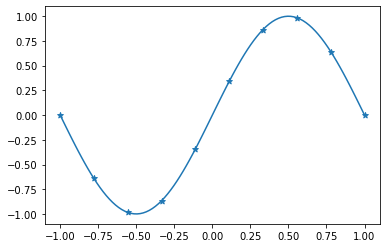

In [11]:
u=u.cpu()
real_x=np.linspace(-1,1,100)
test_x=torch.linspace(-1,1,10)
test=torch.unsqueeze(test_x,dim=1)
plt.scatter(test_x.detach().numpy(),u(test).detach().numpy(),marker='*')
plt.plot(real_x,np.sin(np.pi*real_x))

接下来用PINN求解Helmholtz equation。形式如下：  
$$- u_{xx}-u_{yy} - \pi^2 u = f, \qquad \Omega = [0,1]^2$$
考虑Dirichlet边界条件：  
$$ u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0 $$
令$$f(x,y) = \pi^2\sin(\pi x)\sin(\pi y)$$
其真实解为$$u(x,y)= \sin(\pi x)\sin(\pi y)$$

首先定义内部取点函数以及边界取点函数

In [13]:
def interior(n=1000):
    x=torch.rand(n,1).to(device)
    y=torch.rand(n,1).to(device)
    cond=torch.pi**2*torch.sin(torch.pi*x)*torch.sin(torch.pi*y)
    return x.requires_grad_(True),y.requires_grad_(True),cond

def left(n=100):
    x=torch.zeros(n,1).to(device)
    y=torch.rand(n,1).to(device)
    cond=torch.zeros(n,1).to(device)
    return x.requires_grad_(True),y.requires_grad_(True),cond

def right(n=100):
    x=torch.ones(n,1).to(device)
    y=torch.rand(n,1).to(device)
    cond=torch.zeros(n,1).to(device)
    return x.requires_grad_(True),y.requires_grad_(True),cond

def down(n=100):
    y=torch.zeros(n,1).to(device)
    x=torch.rand(n,1).to(device)
    cond=torch.zeros(n,1).to(device)
    return x.requires_grad_(True),y.requires_grad_(True),cond

def up(n=100):
    y=torch.ones(n,1).to(device)
    x=torch.rand(n,1).to(device)
    cond=torch.zeros(n,1).to(device)
    return x.requires_grad_(True),y.requires_grad_(True),cond

接下来定义内部误差以及边界误差函数，沿用上面的求梯度的方式以及MESloss，输入神经网络，输出误差：

In [14]:
def l_interior(u):
    x,y,cond=interior()
    uxy=u(torch.cat([x,y],dim=1))
    return loss_func(-gradient(uxy,x,2)-gradient(uxy,y,2)-(torch.pi**2)*uxy,cond)

def l_left(u):
    x,y,cond=left()
    uxy=u(torch.cat([x,y],dim=1))
    return loss_func(uxy,cond)

def l_right(u):
    x,y,cond=right()
    uxy=u(torch.cat([x,y],dim=1))
    return loss_func(uxy,cond)

def l_up(u):
    x,y,cond=up()
    uxy=u(torch.cat([x,y],dim=1))
    return loss_func(uxy,cond)

def l_down(u):
    x,y,cond=down()
    uxy=u(torch.cat([x,y],dim=1))
    return loss_func(uxy,cond)

接下来开始训练过程，依然沿用上面所写的Net类，输入改为二维即可，由于对称性，我们对边界的测试误差的验证可以只考虑上边界。

In [15]:
u=Net(2).to(device)
test_inter_x,test_inter_y,_=interior()
test_inter_real=torch.sin(test_inter_x*torch.pi)*torch.sin(test_inter_y*torch.pi)
test_inter_xy=torch.cat([test_inter_x,test_inter_y],dim=1)
test_bound_x,test_bound_y,_=up()
test_bound_xy=torch.cat([test_bound_x,test_bound_y],dim=1)
test_bound_real=torch.zeros_like(test_bound_y).to(device)
num_epoch=3000
optimizer=torch.optim.Adam(u.parameters(),lr=0.01)
step_lr=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.999)
for epoch in range(num_epoch):
    l_i=l_interior(u)
    l_b=l_up(u)
    loss=l_i+l_b+l_down(u)+l_left(u)+l_right(u)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    step_lr.step()
    if epoch%100==0:
        print("----epoch:{}----".format(epoch))
        print("train:")
        print("total_loss:{:.6f}".format(loss))
        print("interior_loss:{:.8f}".format(l_i))
        print("bound_loss:{:.8f}".format(l_b))
        u.eval()
        inter_test_loss=loss_func(u(test_inter_xy),test_inter_real)
        bound_test_loss=loss_func(u(test_bound_xy),test_bound_real)
        print("test:")
        print("interior_loss:{:.8f}".format(inter_test_loss.cpu().detach().numpy()))
        print("bound_loss:{:.8f}".format(bound_test_loss.cpu().detach().numpy()))
        total_loss=inter_test_loss+bound_test_loss
        u.train()       

----epoch:0----
train:
total_loss:32.615921
interior_loss:32.58246613
bound_loss:0.00444723
test:
interior_loss:0.63073826
bound_loss:0.13483405
----epoch:100----
train:
total_loss:4.776610
interior_loss:3.79810119
bound_loss:0.20065425
test:
interior_loss:0.81660277
bound_loss:0.21760270
----epoch:200----
train:
total_loss:0.183781
interior_loss:0.07120389
bound_loss:0.03562880
test:
interior_loss:0.02961368
bound_loss:0.04274525
----epoch:300----
train:
total_loss:0.075970
interior_loss:0.01418677
bound_loss:0.01871381
test:
interior_loss:0.00330967
bound_loss:0.01547060
----epoch:400----
train:
total_loss:0.058056
interior_loss:0.00885940
bound_loss:0.01485595
test:
interior_loss:0.00359872
bound_loss:0.01155829
----epoch:500----
train:
total_loss:0.048894
interior_loss:0.00954242
bound_loss:0.00959059
test:
interior_loss:0.00404458
bound_loss:0.00841297
----epoch:600----
train:
total_loss:0.041623
interior_loss:0.00883028
bound_loss:0.00728372
test:
interior_loss:0.00260322
bound_l

画出解析解的图像与神经网络的求解的图像如下：

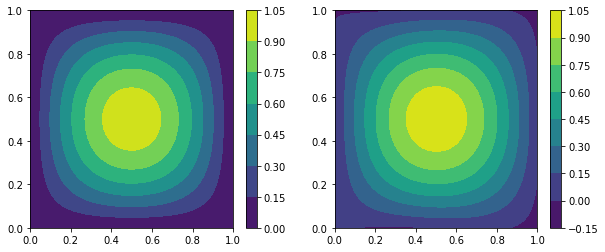

In [16]:
fig=plt.figure(figsize=(10,4))
plt.subplot(121)
x=np.linspace(0,1,100)
y=np.linspace(0,1,100)
x,y=np.meshgrid(x,y)
z_real=np.sin(x*np.pi)*np.sin(y*np.pi)
plt.contourf(x,y,z_real)
cbar1=plt.colorbar()
plt.subplot(122)
u=u.cpu()
test_data=torch.cat([torch.from_numpy(x.reshape(-1,1)),torch.from_numpy(y.reshape(-1,1))],dim=1).float()
z_pred=u(test_data).detach().numpy()
plt.contourf(x,y,z_pred.reshape(100,100))
cbar2=plt.colorbar()

接下来修改权重，提高边界参数比重，代码如下：

In [17]:
u=Net(2).to(device)
test_inter_x,test_inter_y,_=interior()
test_inter_real=torch.sin(test_inter_x*torch.pi)*torch.sin(test_inter_y*torch.pi)
test_inter_xy=torch.cat([test_inter_x,test_inter_y],dim=1)
test_bound_x,test_bound_y,_=up()
test_bound_xy=torch.cat([test_bound_x,test_bound_y],dim=1)
test_bound_real=torch.zeros_like(test_bound_y).to(device)
num_epoch=3000
optimizer=torch.optim.Adam(u.parameters(),lr=0.01)
step_lr=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.999)
for epoch in range(num_epoch):
    l_i=l_interior(u)
    l_b=l_up(u)
    loss=l_i+(l_b+l_down(u)+l_left(u)+l_right(u))*10
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    step_lr.step()
    if epoch%100==0:
        print("----epoch:{}----".format(epoch))
        print("train:")
        print("total_loss:{:.6f}".format(loss))
        print("interior_loss:{:.8f}".format(l_i))
        print("bound_loss:{:.8f}".format(l_b))
        u.eval()
        inter_test_loss=loss_func(u(test_inter_xy),test_inter_real)
        bound_test_loss=loss_func(u(test_bound_xy),test_bound_real)
        print("test:")
        print("interior_loss:{:.8f}".format(inter_test_loss.cpu().detach().numpy()))
        print("bound_loss:{:.8f}".format(bound_test_loss.cpu().detach().numpy()))
        total_loss=inter_test_loss+bound_test_loss
        u.train()       

----epoch:0----
train:
total_loss:23.706585
interior_loss:23.67934418
bound_loss:0.00040778
test:
interior_loss:0.70193529
bound_loss:0.14244293
----epoch:100----
train:
total_loss:3.419684
interior_loss:2.70821881
bound_loss:0.02453660
test:
interior_loss:0.06995454
bound_loss:0.02784252
----epoch:200----
train:
total_loss:0.593725
interior_loss:0.26224044
bound_loss:0.00912750
test:
interior_loss:0.00223116
bound_loss:0.01015785
----epoch:300----
train:
total_loss:0.362248
interior_loss:0.13501166
bound_loss:0.00790139
test:
interior_loss:0.00314391
bound_loss:0.00568616
----epoch:400----
train:
total_loss:0.221302
interior_loss:0.11878426
bound_loss:0.00381916
test:
interior_loss:0.00056532
bound_loss:0.00269965
----epoch:500----
train:
total_loss:0.133182
interior_loss:0.06727121
bound_loss:0.00148200
test:
interior_loss:0.00086132
bound_loss:0.00203098
----epoch:600----
train:
total_loss:0.052064
interior_loss:0.03012817
bound_loss:0.00105089
test:
interior_loss:0.00032322
bound_l

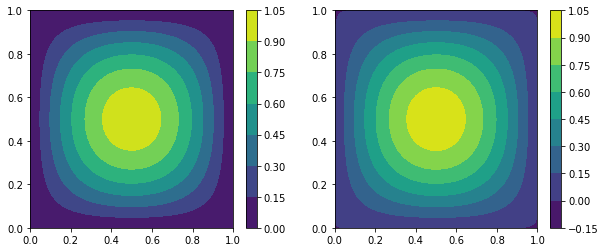

In [18]:
fig=plt.figure(figsize=(10,4))
plt.subplot(121)
x=np.linspace(0,1,100)
y=np.linspace(0,1,100)
x,y=np.meshgrid(x,y)
z_real=np.sin(x*np.pi)*np.sin(y*np.pi)
plt.contourf(x,y,z_real)
cbar1=plt.colorbar()
plt.subplot(122)
u=u.cpu()
test_data=torch.cat([torch.from_numpy(x.reshape(-1,1)),torch.from_numpy(y.reshape(-1,1))],dim=1).float()
z_pred=u(test_data).detach().numpy()
plt.contourf(x,y,z_pred.reshape(100,100))
cbar2=plt.colorbar()